In [55]:
!pip install torch torchvision

In [56]:
!wget https://datahub.ckan.io/dataset/b3dba928-c6f5-431e-90d0-3bb86e8f42a2/resource/feb088a0-9dd0-4938-9187-e3d64fccdbce/download/dataset_test_ahe_64.zip

--2020-12-06 15:47:40--  https://datahub.ckan.io/dataset/b3dba928-c6f5-431e-90d0-3bb86e8f42a2/resource/feb088a0-9dd0-4938-9187-e3d64fccdbce/download/dataset_test_ahe_64.zip
Resolving datahub.ckan.io (datahub.ckan.io)... 34.76.83.194
Connecting to datahub.ckan.io (datahub.ckan.io)|34.76.83.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3872000 (3.7M) [application/zip]
Saving to: ‘dataset_test_ahe_64.zip’

dataset_test_ahe_64 100%[===================>]   3.69M  1.05MB/s    in 4.4s    

2020-12-06 15:47:46 (861 KB/s) - ‘dataset_test_ahe_64.zip’ saved [3872000/3872000]



In [57]:
%pwd

'/content/Dataset_test_64'

In [58]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [61]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
model = model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [62]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/Dataset_test_64'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [63]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [72]:
model_no_ft = models.resnet18(pretrained=True)
num_ftrs = model_no_ft.fc.in_features


for param in model_no_ft.parameters():
    param.requires_grad = False


model_no_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_no_ft = model_no_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_no_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [73]:
best_model_no_ft = train_model(model_no_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8338 Acc: 0.3804
val Loss: 1.0328 Acc: 0.6739

Epoch 1/24
----------
train Loss: 1.3370 Acc: 0.5569
val Loss: 0.6857 Acc: 0.8130

Epoch 2/24
----------
train Loss: 1.2158 Acc: 0.6002
val Loss: 0.7563 Acc: 0.7435

Epoch 3/24
----------
train Loss: 1.1567 Acc: 0.5979
val Loss: 0.7133 Acc: 0.7652

Epoch 4/24
----------
train Loss: 1.1465 Acc: 0.6173
val Loss: 0.6814 Acc: 0.7565

Epoch 5/24
----------
train Loss: 1.0851 Acc: 0.6458
val Loss: 0.6328 Acc: 0.7957

Epoch 6/24
----------
train Loss: 1.0315 Acc: 0.6640
val Loss: 0.6330 Acc: 0.7913

Epoch 7/24
----------
train Loss: 0.9374 Acc: 0.6982
val Loss: 0.5204 Acc: 0.8261

Epoch 8/24
----------
train Loss: 0.8747 Acc: 0.7073
val Loss: 0.5824 Acc: 0.8217

Epoch 9/24
----------
train Loss: 0.8645 Acc: 0.7267
val Loss: 0.5725 Acc: 0.8174

Epoch 10/24
----------
train Loss: 0.9018 Acc: 0.7073
val Loss: 0.5695 Acc: 0.8261

Epoch 11/24
----------
train Loss: 0.9338 Acc: 0.6925
val Loss: 0.5705 Acc: 0.8304

Ep

In [76]:
## Resnet18, finetuned

In [77]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [78]:
best_model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6630 Acc: 0.4328
val Loss: 0.5782 Acc: 0.8087

Epoch 1/24
----------
train Loss: 1.3072 Acc: 0.5672
val Loss: 0.5448 Acc: 0.8348

Epoch 2/24
----------
train Loss: 1.0329 Acc: 0.6720
val Loss: 0.5601 Acc: 0.8174

Epoch 3/24
----------
train Loss: 1.1284 Acc: 0.6481
val Loss: 0.5595 Acc: 0.8391

Epoch 4/24
----------
train Loss: 0.9230 Acc: 0.6993
val Loss: 0.5346 Acc: 0.8348

Epoch 5/24
----------
train Loss: 0.9610 Acc: 0.6936
val Loss: 0.4376 Acc: 0.8609

Epoch 6/24
----------
train Loss: 0.7719 Acc: 0.7551
val Loss: 0.3517 Acc: 0.9174

Epoch 7/24
----------
train Loss: 0.6847 Acc: 0.7756
val Loss: 0.2510 Acc: 0.9130

Epoch 8/24
----------
train Loss: 0.6536 Acc: 0.8075
val Loss: 0.2078 Acc: 0.9348

Epoch 9/24
----------
train Loss: 0.5249 Acc: 0.8257
val Loss: 0.2288 Acc: 0.9174

Epoch 10/24
----------
train Loss: 0.6345 Acc: 0.8041
val Loss: 0.1999 Acc: 0.9217

Epoch 11/24
----------
train Loss: 0.5466 Acc: 0.8292
val Loss: 0.2312 Acc: 0.9217

Ep

## Resnet34

In [79]:
model_ft_34 = models.resnet34(pretrained=True)
num_ftrs = model_ft_34.fc.in_features

model_ft_34.fc = nn.Linear(num_ftrs, len(class_names))

model_ft_34 = model_ft_34.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_34.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


best_model_resnet34 = train_model(model_ft_34, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



Epoch 0/24
----------
train Loss: 1.5987 Acc: 0.4772
val Loss: 0.7088 Acc: 0.8087

Epoch 1/24
----------
train Loss: 1.2255 Acc: 0.6048
val Loss: 0.4508 Acc: 0.8435

Epoch 2/24
----------
train Loss: 1.0225 Acc: 0.6822
val Loss: 0.5528 Acc: 0.8130

Epoch 3/24
----------
train Loss: 1.1171 Acc: 0.6481
val Loss: 0.4770 Acc: 0.8478

Epoch 4/24
----------
train Loss: 0.9631 Acc: 0.7164
val Loss: 0.3797 Acc: 0.8826

Epoch 5/24
----------
train Loss: 0.8957 Acc: 0.7267
val Loss: 0.3981 Acc: 0.8522

Epoch 6/24
----------
train Loss: 0.7986 Acc: 0.7289
val Loss: 0.4344 Acc: 0.8478

Epoch 7/24
----------
train Loss: 0.6705 Acc: 0.7904
val Loss: 0.2787 Acc: 0.8957

Epoch 8/24
----------
train Loss: 0.5723 Acc: 0.8246
val Loss: 0.2632 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.5595 Acc: 0.8303
val Loss: 0.2408 Acc: 0.9043

Epoch 10/24
----------
train Loss: 0.5344 Acc: 0.8303
val Loss: 0.2127 Acc: 0.9217

Epoch 11/24
----------
train Loss: 0.4560 Acc: 0.8542
val Loss: 0.2323 Acc: 0.9217

E

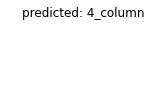

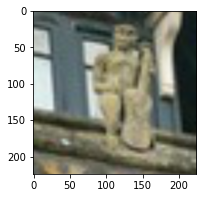

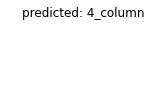

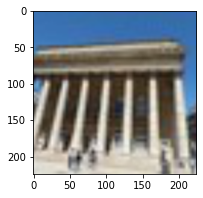

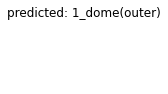

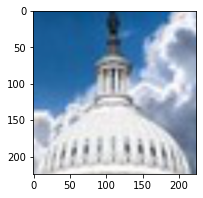

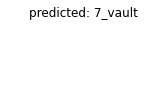

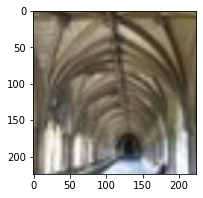

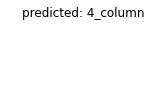

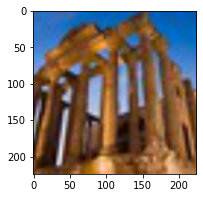

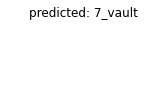

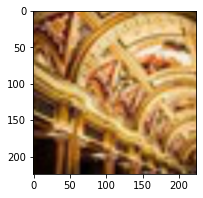

In [83]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure( figsize = (3,3))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



visualize_model(model_ft)



In [51]:
#!rm -rf  /content/Dataset_test_64/val/* 

In [54]:
import glob
from pathlib import Path


c
f2= Path('/content/Dataset_test_64/val').rglob('*.jpg')

len(list(f1)), len(list(f2))

(878, 230)

In [53]:
import random 
import os
import shutil

for path in Path('/content/Dataset_test_64').rglob('*.jpg'):
    
    if random.random()<0.2:
      absolute = str(path.absolute())
      #print(path.absolute())

      new_path = absolute.replace("train", "val")


      dir = os.path.dirname( new_path)    
      os.makedirs(dir,exist_ok=True)
      
      os.rename( absolute, new_path)


In [42]:
random.random()

0.83734369998249